# Modelling Students User Knowledge on Electrical Direct Current Machines

## Introduction:
The dataset used is the User Knowledge Modelling Data Set, which was provided by undergraduate students at the Department of Electrical Education of Gazi University. The data set is composed of a set of variables regarding the study of electrical DC machines and related subjects. It includes standardized double-precision floating-point variables that represent the degree of study time for goal objects (STG), the degree of study repetitions for goal objects (SCG), the degree of study time for related objects (STR), exam performance for related objects (LPR), and exam performance for goal objects (PEG) and a character variable that represents the overall level of knowledge for the goal object (UNS). Information on knowledge level was collected using an intuitive knowledge classifier based on the other variables (Kahraman, Sagiroglu, Colak, 2013). This project will explore the question "Which predictors are most capable of predicting a student's level of knowledge on electrical DC machines through classification, and how effective is the resulting model?". To answer this, predictors from the dataset were analysed and a method for classifying observations with unknown UNS values was developed with chosen predictors from the analysis.  

In [1]:
#Loading relevant libraries
suppressMessages(library(tidyverse))
suppressMessages(library(readxl))
suppressMessages(library(repr))
suppressMessages(library(tidymodels))
suppressMessages(library(GGally))
suppressMessages(library(shiny))

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”


## Method:

The User Knowledge Modelling Data Set is loaded into the file. Because the data is pre-split on 2 separate sheets, this function is used to pull both the training and testing data. The 'very_low' UNS class is converted to 'Very Low' for communication, UNS is mutated into a factor in preparation for classification, and its values are reordered such that they will appear in a logical order on legends.

A small section of the data is called. Upon observation, the data is tidy -- each column is a variable, each row composed of observations, and each cell a singular value. 

In [2]:
#Setting randomizer seed for replication of results
set.seed(2021)

#Downloading file
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "knowledge_data.xls")

#Reading file into R
knowledge_train_chr <- read_excel("knowledge_data.xls", sheet = 2, range = "A1:F259")
knowledge_test_chr <- read_excel('knowledge_data.xls', sheet = 3, range = "A1:F146")

#Reformatting class 
knowledge_train_chr$UNS <- gsub('very_low', 'Very Low', knowledge_train_chr$UNS)
knowledge_test_chr$UNS <- gsub('very_low', 'Very Low', knowledge_test_chr$UNS)

#Converting UNS from <chr> to <fct> 
knowledge_train <- knowledge_train_chr %>%
mutate(UNS = as_factor(UNS))
knowledge_test <- knowledge_test_chr %>%
mutate(UNS = as_factor(UNS))

#Changing order of UNS classes
knowledge_train$UNS <- (factor(knowledge_train$UNS, levels = c('High', 'Middle', 'Low', 'Very Low'))) 
knowledge_test$UNS <- (factor(knowledge_test$UNS, levels = c('High', 'Middle', 'Low', 'Very Low'))) 

#Calling prepared dataframes
titlePanel("Table 1: Sample of Pre-Split Training Data for The User Knowledge Modelling Data Set")
head(knowledge_train)
titlePanel("Table 2: Sample of Pre-Split Testing Data for The User Knowledge Modelling Data Set")
head(knowledge_test)

Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


Given that the data was pre-split, it was important to assess the percentage of the total data within each set and whether each set had similar proportions of each class. The percentage of data split into training is calculated at 64.02% apportioned to the training set, which provided the model with a sufficient amount of data to learn from. The observations per class were found by creating a new dataframe that contained UNS and a column containing the total number of observations of each value. It was found that there were notable differences in the proportioning of the 'Middle' class, which had 34% of the training set and 23% of the testing set) and the 'Very Low' class, which had 9% to 18% respectively. As such, we elected to resplit the data.

In [3]:
#Determining split percentages
training_rows <- nrow(knowledge_train)
testing_rows <- nrow(knowledge_test)

training_percent <- training_rows/(training_rows + testing_rows)
print("Percentage of data apportioned to training")
training_percent

#Finding total number of observations in each UNS class
titlePanel("Table 3: Representation of Each UNS Value Within the Training Set")
class_total_training <- group_by(knowledge_train, UNS) %>%
    summarize(n = n())
class_total_training
titlePanel("Table 4: Representation of Each UNS Value Within the Testing Set")
class_total_testing <- group_by(knowledge_test, UNS) %>%
    summarize(n = n())
class_total_testing

[1] "Percentage of data apportioned to training"


[1] 0.6401985

Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
High,63
Middle,88
Low,83
Very Low,24


Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
High,39
Middle,34
Low,46
Very Low,26


Data is rebound and split with prop = 0.70 and strata = UNS.  Subsequently, the totals of each class are rechecked -- the classes have a proportion difference of less than 1% between each class pair.

In [4]:
#Rebinding and splitting data
knowledge_split <- rbind(knowledge_train, knowledge_test) %>%
initial_split(prop = 0.70, strata = UNS)
knowledge_train <- training(knowledge_split)
knowledge_test <- testing(knowledge_split)

#Finding total number of observations in each UNS class
titlePanel("Table 5: Representation of Each UNS Value Within the Resplit Training Set")
class_total_training <- group_by(knowledge_train, UNS) %>%
    summarize(n = n())
class_total_training
titlePanel("Table 6: Representation of Each UNS Value Within the Resplit Training Set")
class_total_testing <- group_by(knowledge_test, UNS) %>%
    summarize(n = n())
class_total_testing

Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
High,72
Middle,86
Low,91
Very Low,35


Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,n
<fct>,<int>
High,30
Middle,36
Low,38
Very Low,15


Next, predictor variables are selected. First, a correlation matrix for all variables is generated with ggpairs() to assess the predictor variables. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



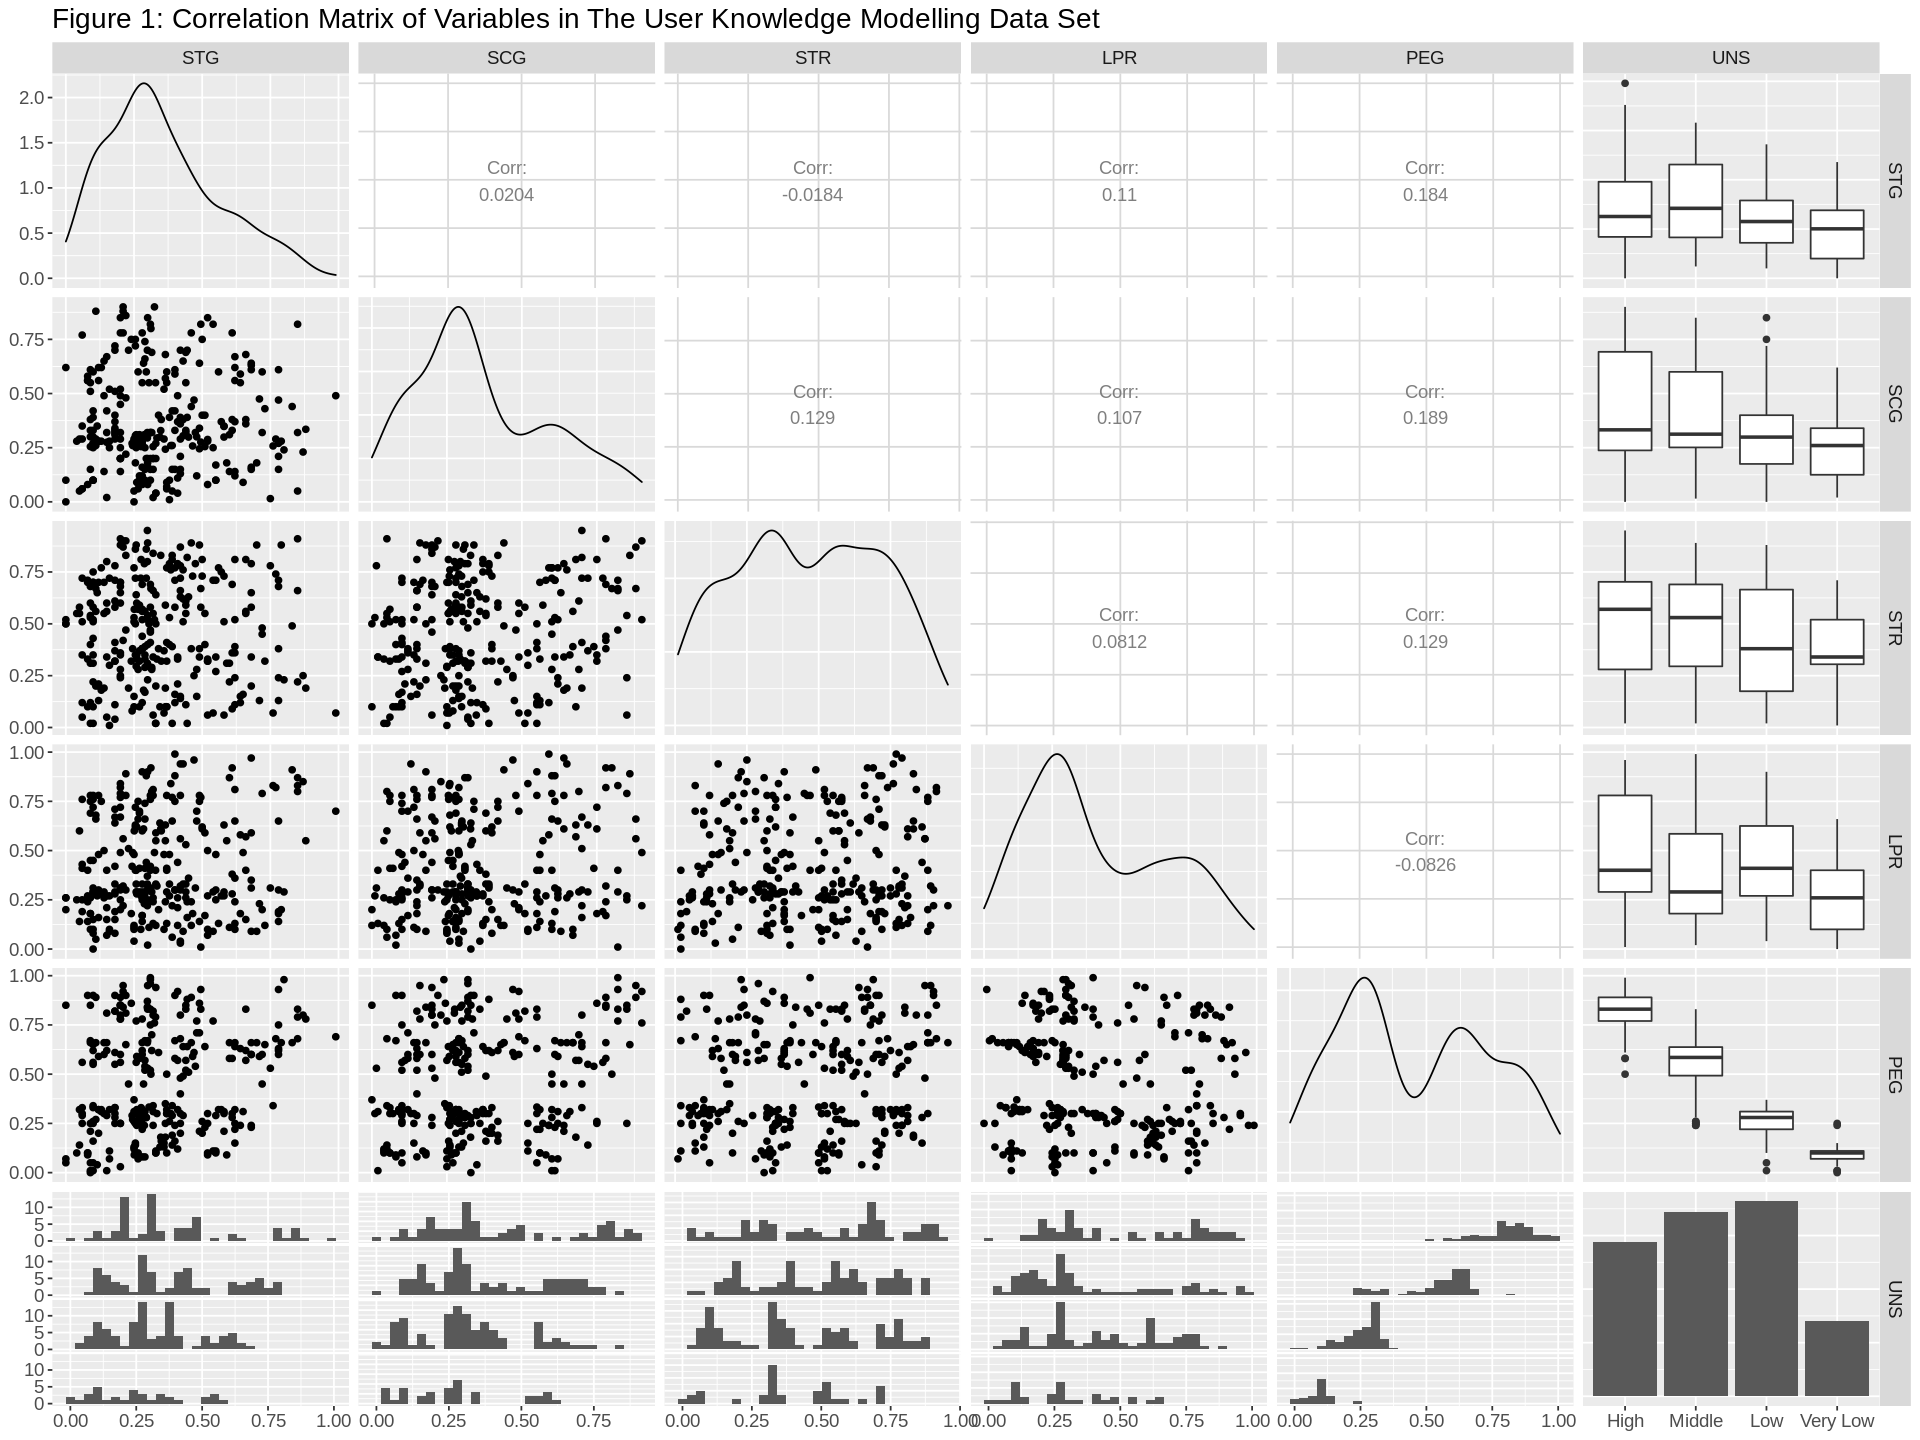

In [5]:
#Setting visualization size
options(repr.plot.width = 16, repr.plot.height = 12) 

#Loading correlation matrix
knowledge_pairs <- knowledge_train %>% 
                    ggpairs() +
                    ggtitle("Figure 1: Correlation Matrix of Variables in The User Knowledge Modelling Data Set") +
                    theme(text = element_text(size = 14))
knowledge_pairs

Predictor variables do not display strong correlations to one another. The highest correlation value found in the matrix is between PEG and SCG at 0.189 followed by PEG and STG at 0.184. The fact that none of these variables seems redundant with one another makes them all potentially viable candidates for the model.

The more valuable information is the set of box plots relating UNS values to each of the predictor variables. PEG stands out as a strong predictor for UNS among the variables -- there is no overlap between interquartile ranges, meaning that PEG values in each UNS class tend to be distinct, and PEG values increase as UNS becomes higher. The rest of the variables do not exhibit trends that immediately suggest they would be strong predictors. STG, SCG, and STR all demonstrate a positive correlation between interquartile range and UNS value, but this trend is weak due to significant interquartile overlap and similar medians between UNS values. LPR does not seem to exhibit any meaningful trends with UNS.

---

Before further coding is performed, it would be prudent to analyze the value of the predictors from a more conceptual perspective.

Research suggests that the time spent studying goal materials (STG) may be positively correlated to factors related to UNS, but results are mixed regarding the strength of this correlation. A study that demonstrates this is Nonis & Hudson (2006). The study rejected its hypothesis that time spent studying outside of class is related to academic performance: a partial positive correlation was found between time spent studying and semester GPA, but not one that was statistically significant. However, when both ACT scores and time spent studying were used in a regression model for GPA, time spent studying had a significant effect on academic performance (Nonis & Hudson, 2006). This implies other factors influence this relationship and that the direct correlation is not strong. 

There is some evidence that the amount of repetitions of goal materials (SCG) is related to UNS, but research suggests that how repetitions are spaced is a more important factor: for an equal number of repetitions, distributed practice will generally be more effective than massed practice (Vlach & Sandhofer, 2012). Because this data only indicates the number of repetitions and not how they were conducted, SCG does not effectively predict UNS.

It is worth noting PEG is not perfect as an indicator for UNS: exams favour people who are good at managing their time and working under stress, meaning that there are individuals with high levels of knowledge on a subject who will not fully demonstrate that knowledge in an exam scenario. A study demonstrating this is Sato, Hill, and Lo, (2019), which had undergraduate students write a mock exam alongside their thought process. It was found that over a quarter of the results showed a discrepancy between exam performance and understanding of the material (Sato, Hill, & Lo, 2019). 

Because STR and LPR measure non-goal objects and their relationship to UNS in the correlation matrix is weak, these variables are removed from consideration.

As the final model will use 2 variables and PEG is guaranteed for use due to its predictive ability on UNS, further analysis is necessary to determine whether STG or SCG is a superior predictor variable. As the research for both is not conclusive, best subset selection will be used between PEG-STG and PEG-SCG. For the remaining preliminary data analysis, both STG and SCG were considered.

---

The mean, minimum, and maximum values and the total number of NA values for possible predictors STG, SCG, and PEG are collected for the training data set. These values are also collected for the testing set for comparative purposes. 

STG has a mean of 0.35, and SCG a mean of 0.36 -- comparing this with the STG and SCG means for the testing data, it seems clear that this is not due to issues with the split but rather because STG values skew closer to 0 than 1. PEG has a mean of 0.46, closer to the middle of the possible range. Both STG and PEG values range from 0 to 0.99, and SCG values range from 0 to 0.9 -- with a maximum possible value of 1, data values are seen across most of the possible range. No NA values are found.

In [6]:
#Checking mean, min/max values, and total missing values in relevant variables
titlePanel('Table 7: Summary Statistics on Potential Predictor Variables STG, SCG, and PEG in Training Data')
train_stats <- select(knowledge_train, STG, SCG, PEG) %>%
    summarize(STG_mean = mean(STG), STG_min = min(STG), STG_max = max(STG), STG_na_total = sum(is.na(STG)), SCG_mean = mean(SCG), SCG_min = min(SCG), SCG_max = max(SCG), SCG_na_total = sum(is.na(SCG)), PEG_mean = mean(PEG), PEG_min = min(PEG), PEG_max = max(PEG), PEG_na_total = sum(is.na(PEG)))
train_stats

titlePanel('Table 8: Summary Statistics on Potential Predictor Variables STG, SCG, and PEG in Testing Data')
test_stats <- select(knowledge_test, STG, SCG, PEG) %>%
    summarize(STG_mean = mean(STG), STG_min = min(STG), STG_max = max(STG), STG_na_total = sum(is.na(STG)), SCG_mean = mean(SCG), SCG_min = min(SCG), SCG_max = max(SCG), SCG_na_total = sum(is.na(SCG)), PEG_mean = mean(PEG), PEG_min = min(PEG), PEG_max = max(PEG), PEG_na_total = sum(is.na(PEG)))
test_stats

Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

STG_mean,STG_min,STG_max,STG_na_total,SCG_mean,SCG_min,SCG_max,SCG_na_total,PEG_mean,PEG_min,PEG_max,PEG_na_total
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
0.351081,0,0.99,0,0.3631092,0,0.9,0,0.4628275,0,0.99,0


Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

STG_mean,STG_min,STG_max,STG_na_total,SCG_mean,SCG_min,SCG_max,SCG_na_total,PEG_mean,PEG_min,PEG_max,PEG_na_total
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
0.3580588,0,0.91,0,0.3388319,0,0.9,0,0.4409244,0,0.97,0


Scatter plots are generated to visualize the relationship between predictor variables STG or SCG (x) and PEG (y). 

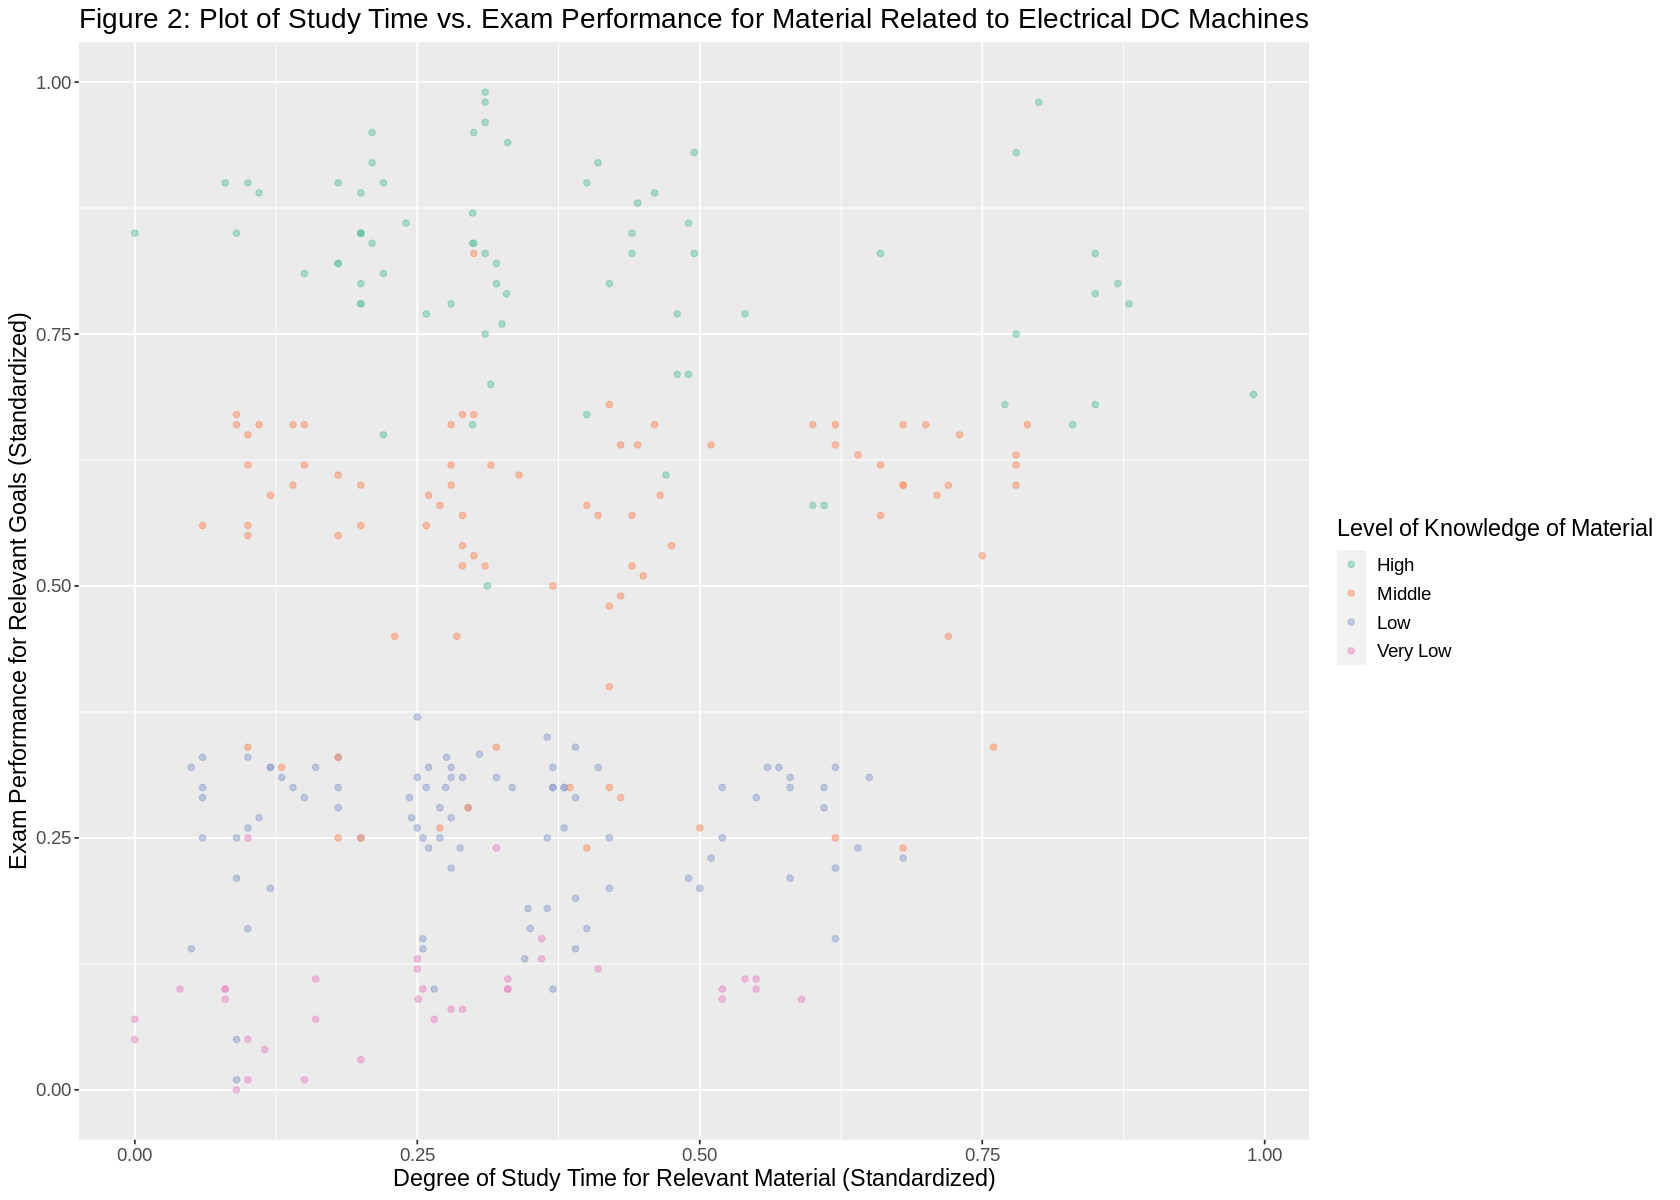

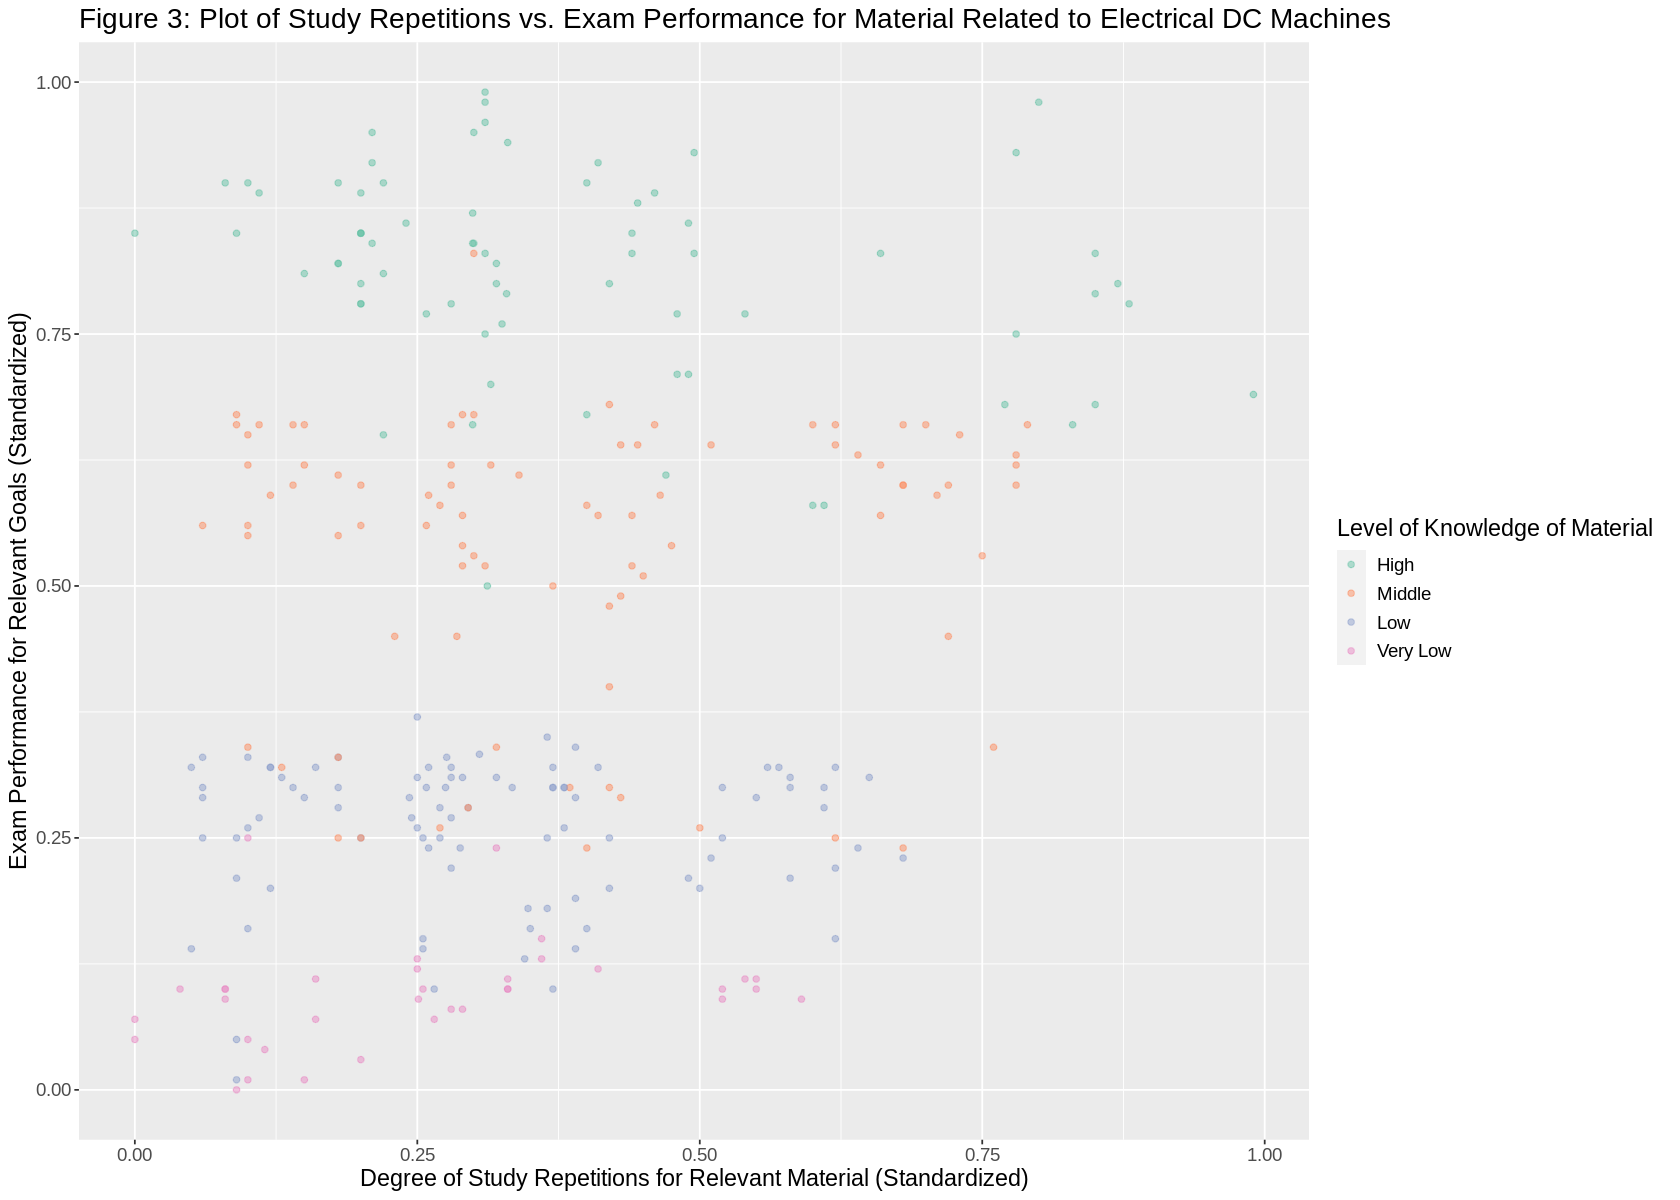

In [7]:
#Setting visualization size
options(repr.plot.width = 14, repr.plot.height = 10) 

#Creating STG plot
knowledge_plot_STG <- ggplot(knowledge_train, aes(x = STG, y = PEG, color = UNS)) +
    geom_point(alpha = 0.5) + 
    labs(x = 'Degree of Study Time for Relevant Material (Standardized)', y = 'Exam Performance for Relevant Goals (Standardized)', color = 'Level of Knowledge of Material') +
    ggtitle("Figure 2: Plot of Study Time vs. Exam Performance for Material Related to Electrical DC Machines") +
    theme(text = element_text(size = 14)) +
    scale_color_brewer(palette = 'Set2') 
knowledge_plot_STG

#Creating SCG plot
knowledge_plot_SCG <- ggplot(knowledge_train, aes(x = STG, y = PEG, color = UNS)) +
    geom_point(alpha = 0.5) + 
    labs(x = 'Degree of Study Repetitions for Relevant Material (Standardized)', y = 'Exam Performance for Relevant Goals (Standardized)', color = 'Level of Knowledge of Material') +
    ggtitle("Figure 3: Plot of Study Repetitions vs. Exam Performance for Material Related to Electrical DC Machines") +
    theme(text = element_text(size = 14)) +
    scale_color_brewer(palette = 'Set2') 
knowledge_plot_SCG

The relationship between PEG and either of the other 2 variables is very weak. It seems as if PEG is the driving force of UNS classification in both variable sets -- classes are split into what are essentially vertical strata that for the most part occupy their own regions on the graph. In both graphs, however, there is significant intermixing between the 'Low' and 'Very Low' observations.

A model using STG and PEG as predictors and a model using SCG and PEG as predictors are compared based upon the accuracy of their predictions of the testing data. To do this, an optimal K-value is found for both models and metrics are collected based on predictions. To choose K, a workflow is created that uses a recipe specifying the dataset and predictor/classifier variables, a model specifying classification with kknn and the tune function for the number of neighbours, and tune_grid, which calls a 5-fold cross-validation with a grid containing values from 1 to 10. Metrics are collected for accuracy estimates for each grid value, which are then plotted. The following code sets out this process for STG:

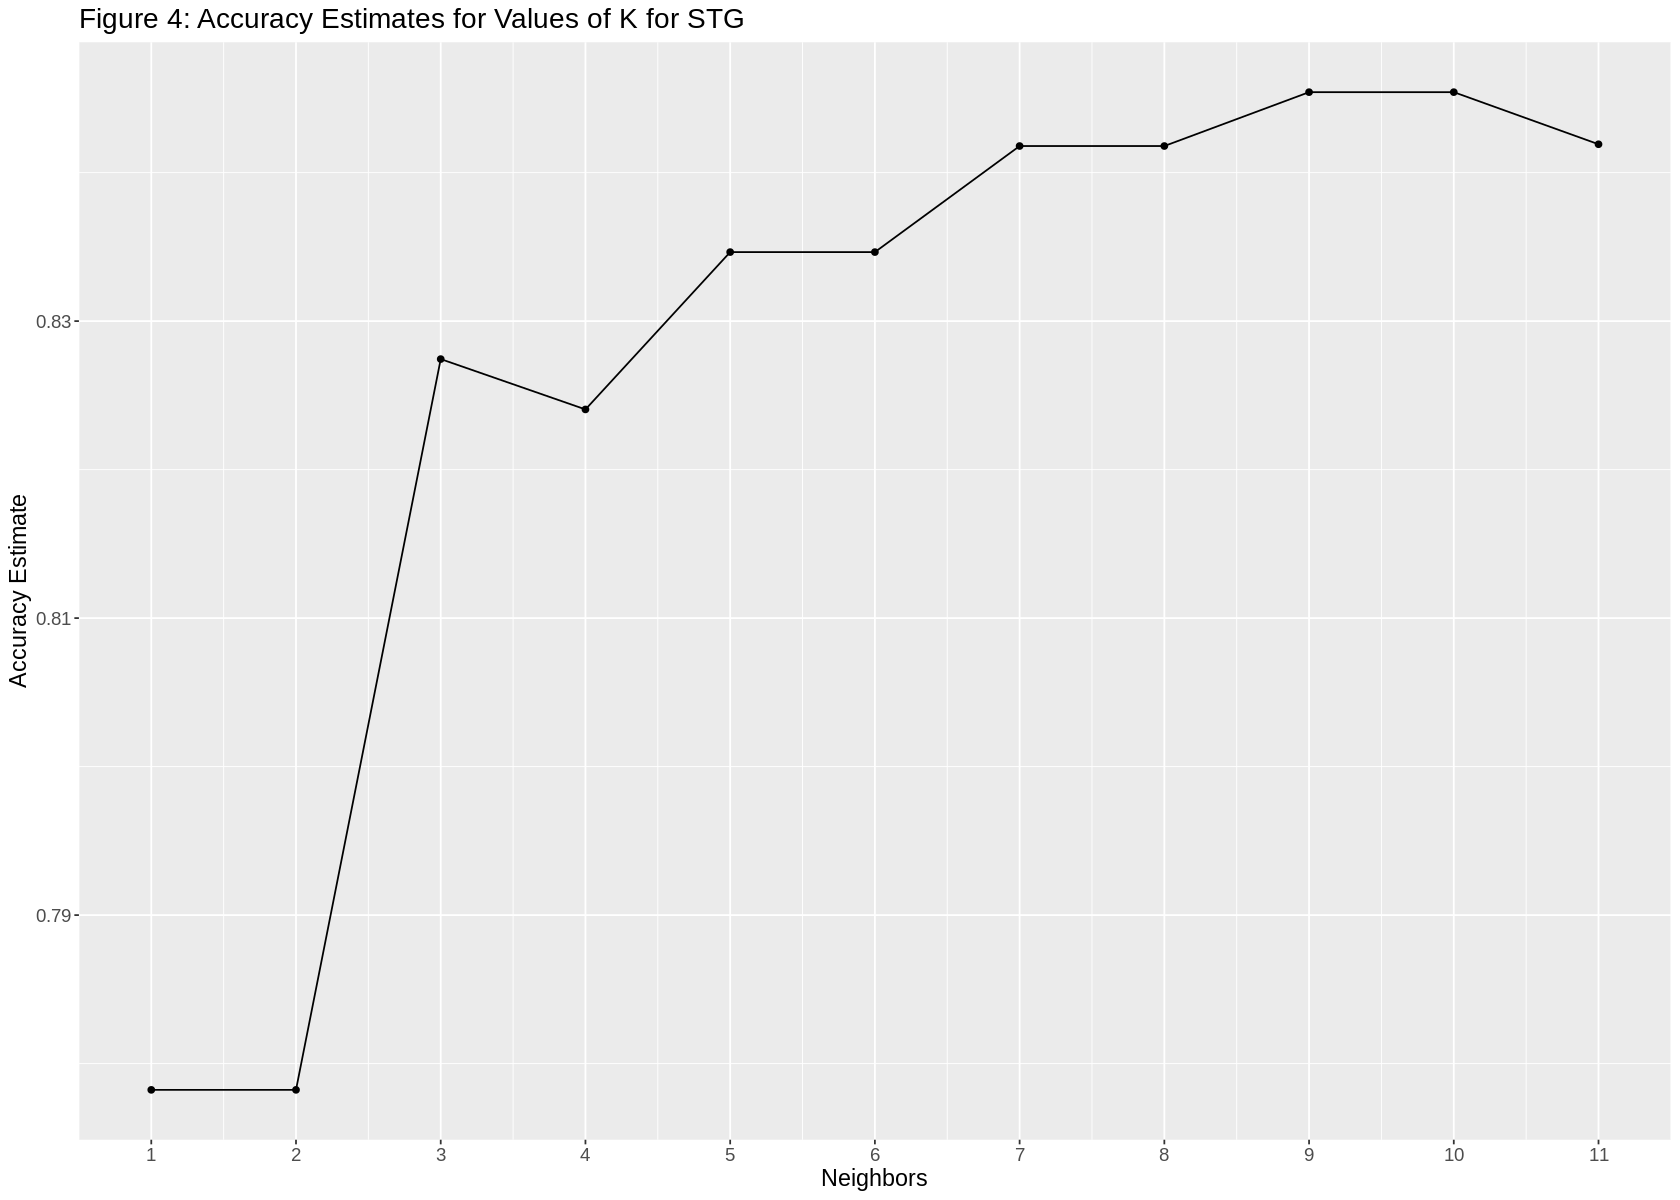

In [8]:
#Setting visualization size
options(repr.plot.width = 14, repr.plot.height = 10) 

#Creating recipe
STG_recipe <- recipe(UNS ~ PEG + STG, data = knowledge_train)

#Creating tuning specifications
STG_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#Setting grid values + cross-validation specifications for tune_grid()
gridvals <- tibble(neighbors = seq(1:11))
knowledge_vfold <- vfold_cv(knowledge_train, v = 5, strata = UNS)

#Producing a workflow using tune_grid() to perform cross-validation, collecting accuracy metrics
STG_results <- workflow() %>%
                    add_recipe(STG_recipe) %>%
                    add_model(STG_tune) %>%
                    tune_grid(resamples = knowledge_vfold, grid = gridvals) %>%
                    collect_metrics() %>%
                    filter(.metric == "accuracy")
                    
#Plotting accuracy metrics against k values
STG_crossval_plot <- STG_results %>% 
                            ggplot(aes(x = neighbors, y = mean)) +
                            geom_point() + 
                            geom_line() +
                            labs(x = "Neighbors", y = "Accuracy Estimate") +
                            ggtitle("Figure 4: Accuracy Estimates for Values of K for STG") + 
                            scale_x_continuous(breaks = seq(1,11, by = 1)) + 
                            theme(text = element_text(size=14))

STG_crossval_plot

K = 9 was chosen as it possesses the highest accuracy estimate of the range at 0.845. Its neighbours had small accuracy differences, which made K = 9 more reliable in the presence of uncertainty. K = 9 was chosen over the equal K = 10 as larger K values are more demanding from a processing perspective. Although only K values up to 10 are considered due to processing concerns, K = 11 is graphed to determine whether K = 10's closest neighbours maintain a more stable accuracy estimate than K = 9's, which is not the case. 

Using the K value acquired above, a workflow is created with a new kknn engine specification that fits the data to knowledge_train. The fitted model is then used to predict the classes of data in the knowledge_test dataset, and accuracy metrics are generated.

In [9]:
#Setting new model specifications with selected K value
STG_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#Creating new workflow with new specifications and fit()
STG_fit <- workflow() %>%
                    add_recipe(STG_recipe) %>%
                    add_model(STG_spec) %>%
                    fit(data = knowledge_train)

#Predicting the knowledge_test set with the model. The knowledge_test dataframe is bound to the prediction dataframe for metrics.
STG_predict <- STG_fit %>%
                    predict(knowledge_test) %>%
                    bind_cols(knowledge_test)

#Collecting metrics
STG_metrics <- STG_predict %>%
                    metrics(truth = UNS, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy') %>%
                    select(.estimate) %>%
                    pull()
print("Accuracy of Predictions on Training Data at K = 9 for STG:")
STG_metrics

[1] "Accuracy of Predictions on Training Data at K = 9 for STG:"


[1] 0.8067227

The process of finding optimal K and collecting metrics on the model is repeated for SCG:

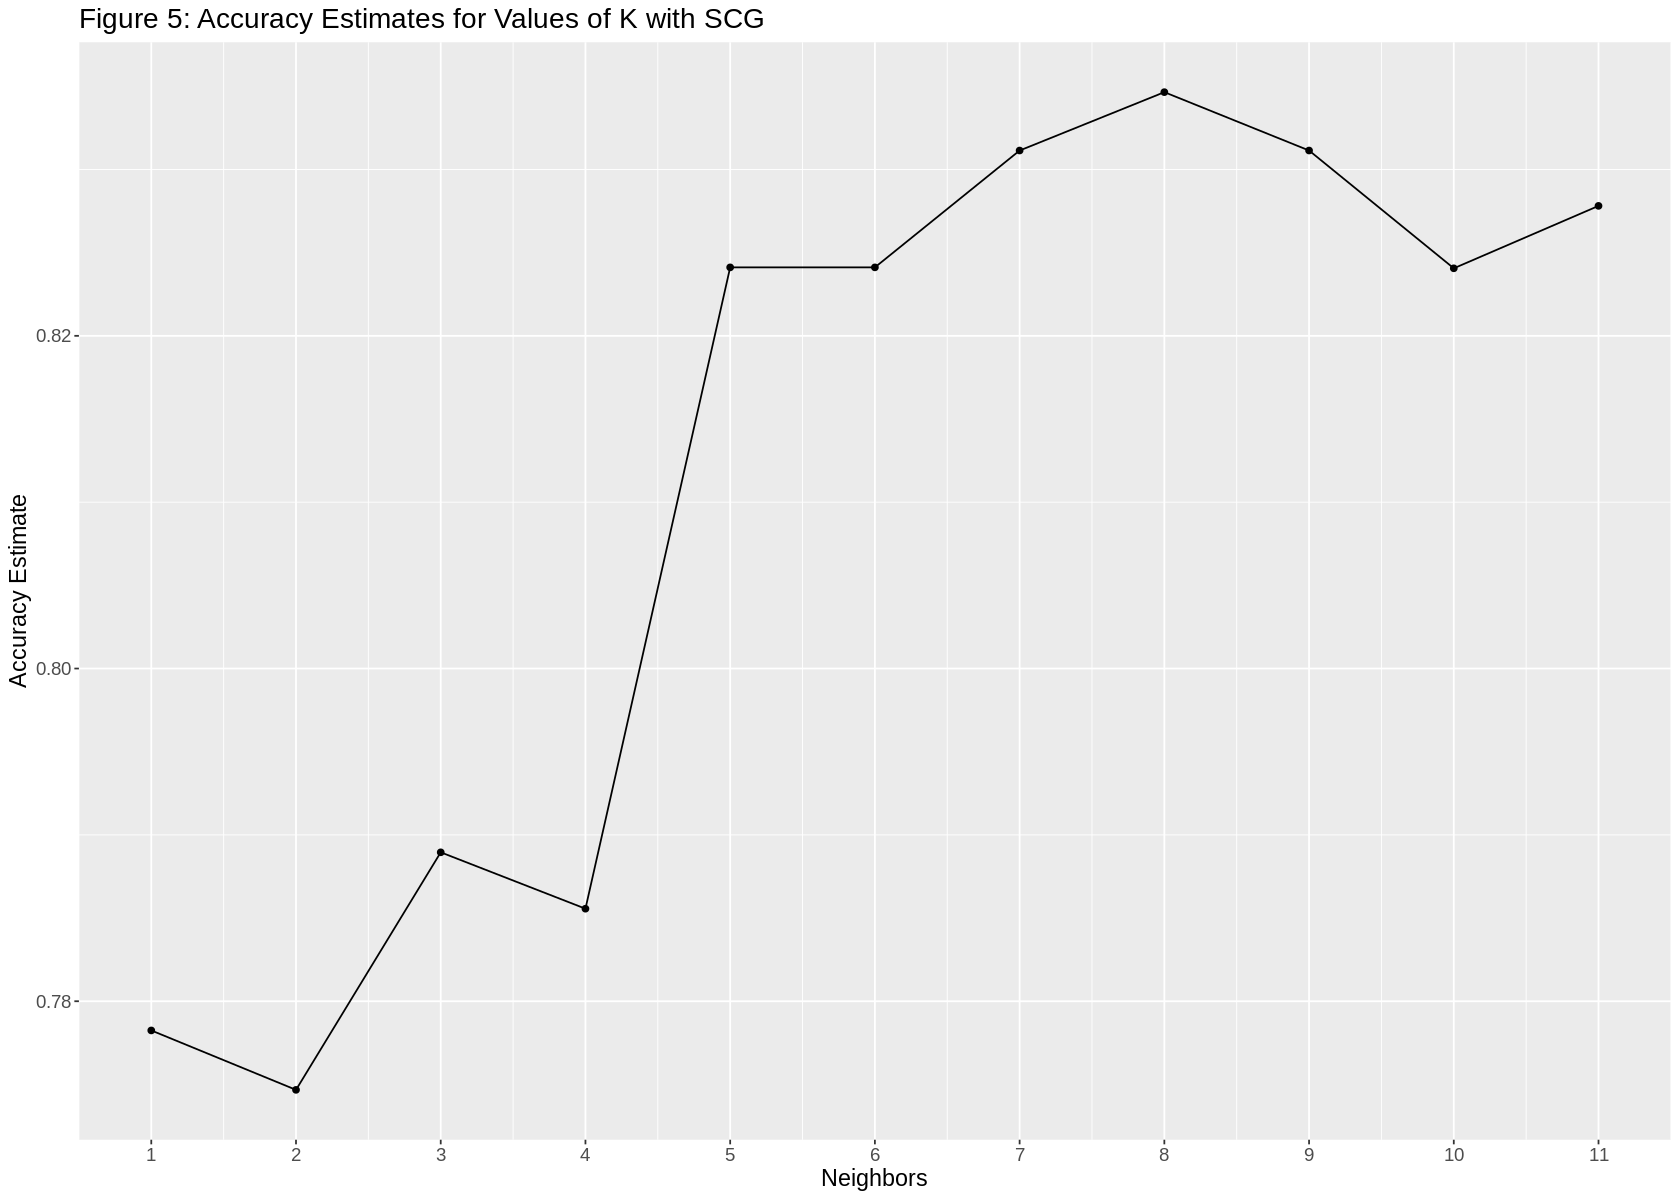

In [10]:
#Setting visualization size
options(repr.plot.width = 14, repr.plot.height = 10) 

#Creating recipe
SCG_recipe <- recipe(UNS ~ PEG + SCG, data = knowledge_train)

#Creating tuning specifications
SCG_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#Producing a workflow using tune_grid() to perform cross-validation, collecting accuracy metrics
SCG_results <- workflow() %>%
                    add_recipe(SCG_recipe) %>%
                    add_model(SCG_tune) %>%
                    tune_grid(resamples = knowledge_vfold, grid = gridvals) %>%
                    collect_metrics() %>%
                    filter(.metric == "accuracy")
                    
#Plotting accuracy metrics against k values
SCG_crossval_plot <- SCG_results %>% 
                            ggplot(aes(x = neighbors, y = mean)) +
                            geom_point() + 
                            geom_line() +
                            labs(x = "Neighbors", y = "Accuracy Estimate") +
                            ggtitle("Figure 5: Accuracy Estimates for Values of K with SCG") + 
                            scale_x_continuous(breaks = seq(1,11, by = 1)) + 
                            theme(text = element_text(size=14))

SCG_crossval_plot

K = 8 is chosen as it possesses the highest accuracy estimate at ~0.835 and its neighbour accuracy estimate values are not significantly different.

In [11]:
#Setting new model specifications with selected K value
SCG_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

#Creating new workflow with new specifications and fit()
SCG_fit <- workflow() %>%
                    add_recipe(SCG_recipe) %>%
                    add_model(SCG_spec) %>%
                    fit(data = knowledge_train)

#Predicting the knowledge_test set with the model. The knowledge_test dataframe is bound to the prediction dataframe for metrics.
SCG_predict <- SCG_fit %>%
                    predict(knowledge_test) %>%
                    bind_cols(knowledge_test)

#Collecting metrics
SCG_metrics <- SCG_predict %>%
                    metrics(truth = UNS, estimate = .pred_class) %>%
                    filter(.metric == 'accuracy') %>%
                    select(.estimate) %>%
                    pull()
print("Accuracy of Predictions on Training Data at K = 8 for SCG:")
SCG_metrics

[1] "Accuracy of Predictions on Training Data at K = 8 for SCG:"


[1] 0.789916

Based on best subset selection,  STG and PEG were a superior combination of predictor variables to SCG and PEG. This choice was made based on the accuracy of prediction for STG-PEG and SCG-PEG, which generated results of 0.80672268907563 and 0.789915966386555 respectively. However, the variables perform similarly, and there is a reasonable argument to be made that SCG could return a better accuracy value in a reshuffled training data set. 

A confusion matrix is produced for the model predicting with STG and PEG.

In [12]:
#Producing a confusion matrix
titlePanel("Table 9: Confusion Matrix for Model Predictions on Testing Data")
knowledge_conf <- STG_fit %>%
                    predict(knowledge_test) %>%
                    bind_cols(knowledge_test) %>%
                    conf_mat(truth = UNS, estimate = .pred_class) 
knowledge_conf

Warning message in repr_html.shiny.tag.list(obj):
“Inserting HTML strings into <head> is currently not supported”


Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction High Middle Low Very Low
  High       22      0   0        0
  Middle      8     29   0        0
  Low         0      7  33        3
  Very Low    0      0   5       12

2 scatter plots are created, both of STG and PEG from the testing data set. The first visualization uses knowledge_predict and colours observations based on .pred_class, which contains predicted UNS values, while the second uses knowledge_test and colours observations based on their actual UNS values. 

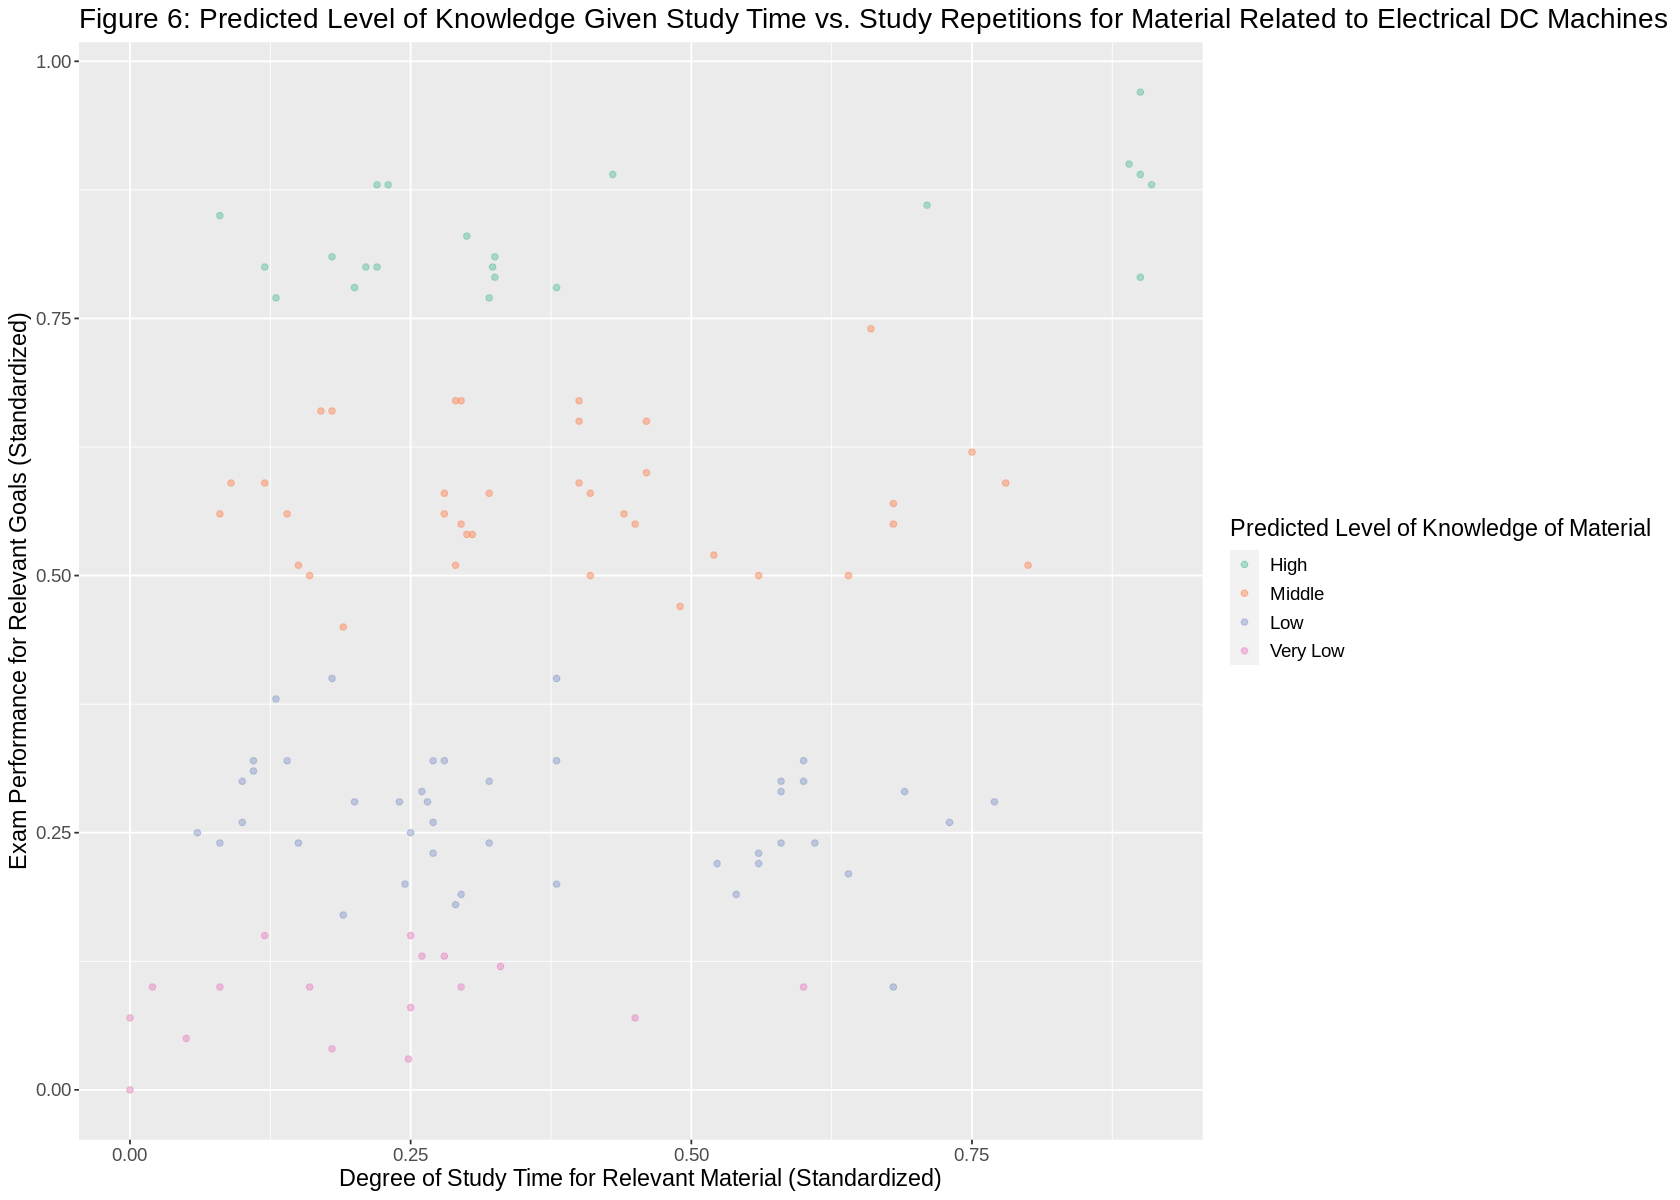

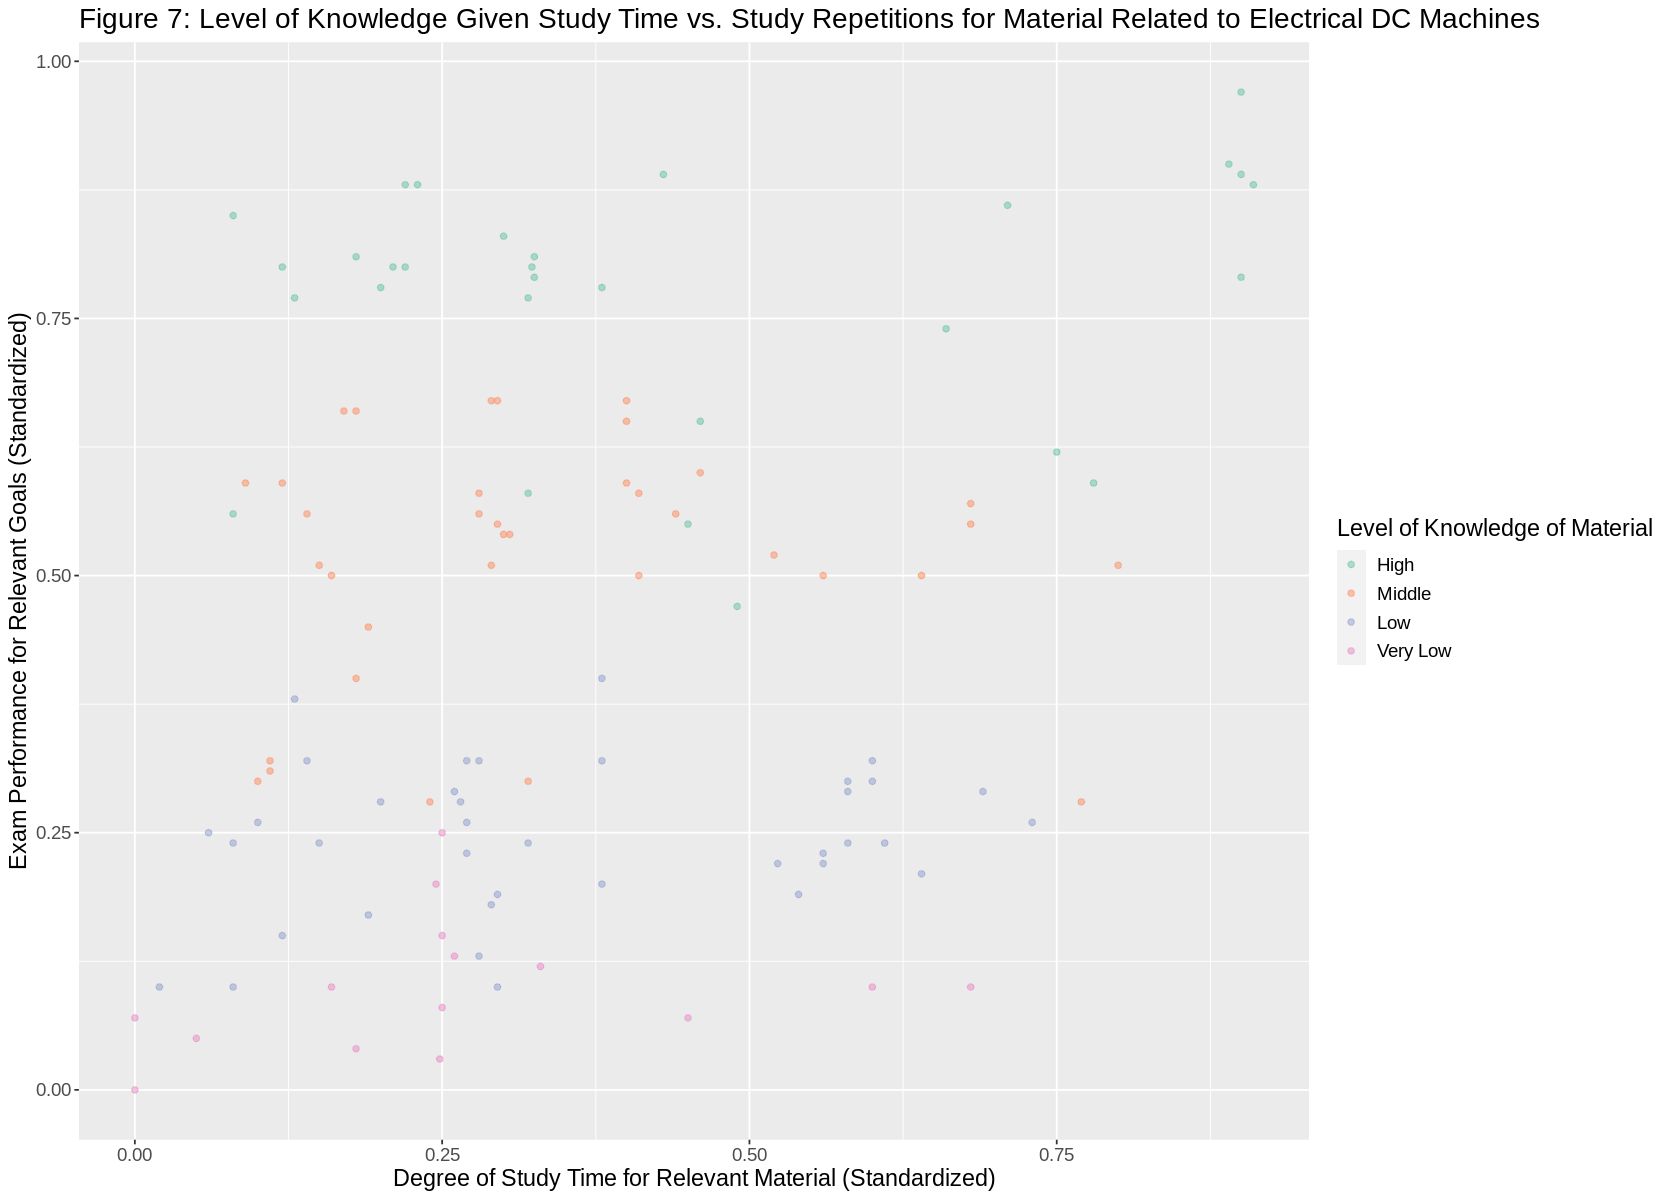

In [13]:
#Setting visualization size
options(repr.plot.width = 14, repr.plot.height = 10) 

#Building plot of predicted training set class values
knowledge_prediction_plot <- ggplot(STG_predict, aes(x = STG, y = PEG, color = .pred_class)) +
    geom_point(alpha = 0.5) + 
    labs(x = 'Degree of Study Time for Relevant Material (Standardized)', y = 'Exam Performance for Relevant Goals (Standardized)', color = 'Predicted Level of Knowledge of Material') +
    ggtitle("Figure 6: Predicted Level of Knowledge Given Study Time vs. Study Repetitions for Material Related to Electrical DC Machines") +
    theme(text = element_text(size = 14)) +
    scale_color_brewer(palette = 'Set2') 

#Building plot of actual training set class values
knowledge_test_plot <- ggplot(knowledge_test, aes(x = STG, y = PEG, color = UNS)) +
    geom_point(alpha = 0.5) + 
    labs(x = 'Degree of Study Time for Relevant Material (Standardized)', y = 'Exam Performance for Relevant Goals (Standardized)', color = 'Level of Knowledge of Material') +
    ggtitle("Figure 7: Level of Knowledge Given Study Time vs. Study Repetitions for Material Related to Electrical DC Machines") +
    theme(text = element_text(size = 14)) +
    scale_color_brewer(palette = 'Set2') 

knowledge_prediction_plot
knowledge_test_plot

## Discussion
### Summary of Results
Our model performed at an accuracy of 80.67% on its predictions. Reviewing the confusion matrix, the model made the highest proportion of errors predicting the ‘Low’ class -- 7 members of the ‘Middle’ and 3 members of the ‘Very Low’ classes were misclassified as ‘Low’. Members of the ‘Low’ class itself were not as frequently mispredicted, with 5 misattributions to the ‘Very Low’ class. Observations of the ‘High’ class had 8 misattributions to the ‘Middle’ class, but none in the opposite direction. These findings make sense given the previously-discussed ‘stratification’ of classes in the data from PEG values. There are several observations in the training and testing data of the ‘Middle’ and ‘Very Low’ classes with PEG values closer to the average PEG value of the ‘Low’ class, but very few of the ‘Low’ class with average PEG values close to the ‘Middle’ class and only a small amount with an average PEG value close to the ‘Very Low’ class. Similarly, with regards to the misattributions in the ‘High’ class: although there were some members of the ‘High’ class with a PEG score closer to the average PEG score of the ‘Middle’ class, there were very few members of the ‘Middle’ class with a PEG score closer to the average of the ‘High’ class. All this serves to explain why the model made the specific mistakes it did. 

#### Was this Expected?

Based on our accuracy estimations we expected that there would be observations that would be predicted incorrectly. Because of the low correlation between PEG and STG, the areas where the class strata ‘mixed’ become very difficult to predict for the model. This is particularly evident between the “Low” and “Middle” and "High” and "Middle" classes, where a majority of misclassifications occurred.

Overall, it is not surprising that UNS classification is driven by PEG -- this notion is backed up by our research and preliminary analysis. This does not necessarily mean a better choice for a second variable than STG was available, given that the only predictor strongly correlated to UNS was PEG; it does, however, suggest that to improve this model it would be worthwhile to consider new variables outright.

#### Impacts & Answering the Research Question
This model clarifies that study time alone is not a valuable metric for assessing UNS, and should not be considered independently as an indicator for knowledge, and that while exams are a strong indicator of knowledge, they are not a full representation of knowledge. Additionally, the ability to determine a student’s level of knowledge through classification can be useful to assess the effectiveness of teaching strategies. 

All of the above discussion combined with the analysis of variables earlier in the report serves to answer our question. Regarding variable choice for the classification model, it has been made quite clear PEG is by far the strongest predictor for UNS. Theoretically, STG and SCG are the next strongest as STR and LPR by virtue of their indirect relation to knowledge of the goal object; of these variables, STG was found to be stronger through accuracy comparisons, but neither variable had a particularly strong correlation to UNS from a theoretical perspective or in the data at hand. Regarding the success of the model – Given that the established use-cases for this model are not radical, critical, or potentially life-changing, we argue that an accuracy of 80.67% is not bad in context; however, the model is ultimately too reliant on PEG as a predictor to generate meaningful information that cannot be found from PEG values alone.

#### Future Investigations
It should be investigated what elements of studying are more strongly correlated with high levels of knowledge if not time or repetitions -- this may lead to superior classification models for UNS. Besides the studying variables, many other predictors may influence levels of knowledge, such as health, interest in academics, and stress level. This study may also lead to investigations of whether study time is a better predictor for UNS when working in conjunction with other variables.

## References  
Kahraman, H.T., Sagiroglu, S., Colak, I. (2013). The development of intuitive knowledge classifier and modeling of understanding domain dependent 	
     data. _Knowledge Based Systems_, 37, 283-295. DOI: 10.1016/j.knosys.2012.08.009

Nonis, S. A., &amp; Hudson, G. I. (2006). Academic performance of college students: Influence of time spent studying and working. Journal of 		
     Education for Business, 81(3), 151–159. DOI: 10.3200/joeb.81.3.151-159 

Sato, B.K., Hill, C., and Lo, S.M. (2019). Testing the test: are exams measuring understanding?" _Biochemistry and Molecular Biology Education_, 	 
     47(3), 296-302. DOI: 10.1002/bmb.21231

Vlach, H. A., &amp; Sandhofer, C. M. (2012). Distributing learning over time: The spacing effect in children’s acquisition and generalization of science concepts. Child Development, 83(4), 1137–1144. DOI: 10.1111/j.1467-8624.2012.01781.x 